# QC, normalization to UMAP of microtissue (cDNA5) samples from shallow sequencing
### By Maks Necki
### __16.02.2026__

###### Loading required libraries:

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import scipy as sp
import scipy.stats as stats
import logging
import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

In [36]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


###### Loading count matrix:

In [37]:
adatas = [
    sc.read_10x_h5(filename = "/mnt/dysk_D/NIKARD_35_probek/demultiplex_results/cDNA5_OCM_demux/outs/per_sample_outs/Sample1/count/sample1_filtered_feature_bc_matrix.h5"),
    sc.read_10x_h5(filename = "/mnt/dysk_D/NIKARD_35_probek/demultiplex_results/cDNA5_OCM_demux/outs/per_sample_outs/Sample2/count/sample2_filtered_feature_bc_matrix.h5"),
    sc.read_10x_h5(filename = "/mnt/dysk_D/NIKARD_35_probek/demultiplex_results/cDNA5_OCM_demux/outs/per_sample_outs/Sample3/count/sample3_filtered_feature_bc_matrix.h5"),
    sc.read_10x_h5(filename = "/mnt/dysk_D/NIKARD_35_probek/demultiplex_results/cDNA5_OCM_demux/outs/per_sample_outs/Sample4/count/sample4_filtered_feature_bc_matrix.h5")
]

/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/anndata/_

###### Generating unique gene names:

In [38]:
for ad in adatas:
    ad.var_names_make_unique()

###### Adding sample ID

In [39]:
for i, ad in enumerate(adatas):
    ad.obs["sample"] = f"sample_{i+1}"

###### concatenate:

In [40]:
adata = sc.concat(
    adatas,
    join="outer",
    axis=0,
    label="sample",
    keys=["CM_2D", "FB_2D", "FB_3D", "CM_FB_3D"],
    index_unique="-"
)

###### Filtering low quality cells:

###### Before QC:

In [41]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.startswith(("HB[^(P)]"))

###### We can now calculate the respective QC metrics with scanpy:

In [42]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 18036 × 38606
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

###### We want to highlight by several plots low quality of cells:
###### - `n_genes_by_counts` in `.obs` is the number of genes with positive counts in a cell
###### - `total_counts` is the total number of counts for a cell, this might be known as a library size
###### - `pct_counts_mt` is the proportion of total counts for a cell which are mitochondrial

###### `pct_counts`:

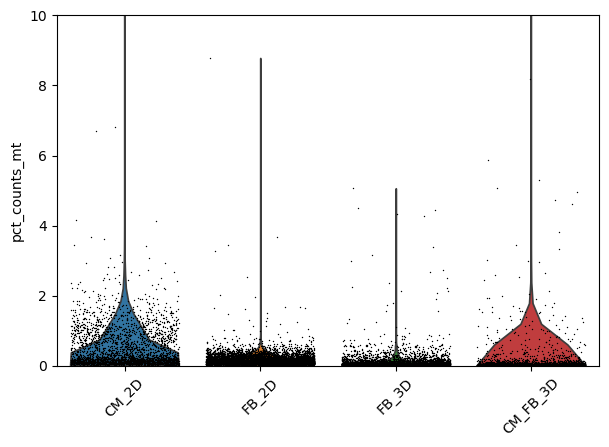

In [43]:
ax = sc.pl.violin(
    adata,
    ["pct_counts_mt"],
    groupby="sample",
    jitter=0.4,
    rotation=45,
    show=False
)

# ustawiamy limit osi Y
ax.set_ylim(0, 10)

plt.show()

###### `total_counts`:

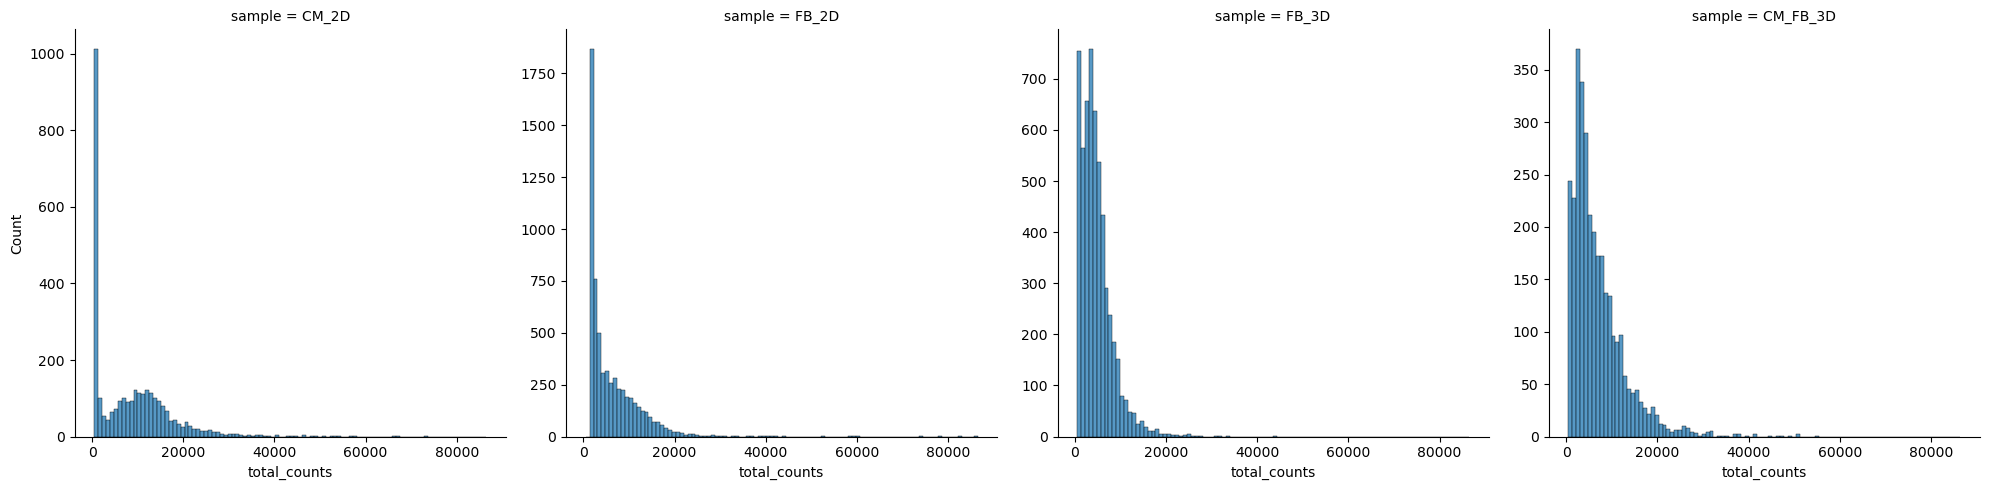

In [44]:
sns.displot(
    data=adata.obs,
    x="total_counts",
    col="sample",
    bins=100,
    facet_kws=dict(sharex=False, sharey=False)
)
plt.show()

###### Now based on this results we can come to conclusion that automatic thresholding based on given MAD should be more than enough for this analysis:

In [45]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * stats.median_abs_deviation(M)) | (
        np.median(M) + nmads * stats.median_abs_deviation(M) < M
    )
    return outlier

###### We apply this function to the `log1p_total_counts`, `log1p_n_genes_by_counts` and `pct_counts_in_top_20_genes` QC covariates each with a threshold of 5 MADs

In [46]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    17744
True       292
Name: count, dtype: int64

In [47]:
adata.write("microtissue_before_quality_control.h5ad")

In [27]:
%%R 
#BiocManager::install("zellkonverter")
library(Seurat)
library(scry)
library(zellkonverter)
library(SingleCellExperiment)
library(patchwork)
library(ggplot2)
library(dplyr)


Dołączanie pakietu: ‘dplyr’

Następujący obiekt został zakryty z ‘package:Biobase’:

    combine

Następujące obiekty zostały zakryte z ‘package:GenomicRanges’:

    intersect, setdiff, union

Następujący obiekt został zakryty z ‘package:Seqinfo’:

    intersect

Następujące obiekty zostały zakryte z ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union

Następujące obiekty zostały zakryte z ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union

Następujące obiekty zostały zakryte z ‘package:BiocGenerics’:

    combine, intersect, setdiff, setequal, union

Następujący obiekt został zakryty z ‘package:generics’:

    explain

Następujący obiekt został zakryty z ‘package:matrixStats’:

    count

Następujące obiekty zostały zakryte z ‘package:stats’:

    filter, lag

Następujące obiekty zostały zakryte z ‘package:base’:

    intersect, setdiff, setequal, union

Dodatkowo: Komunikat ostrzegawczy:
pakiet ‘ggplot2’ został zbudowany w wersji R 4.5.

<sys>:0: FutureWarning: Use varm (e.g. `k in adata.varm` or `adata.varm.keys() | {'u'}`) instead of AnnData.varm_keys, AnnData.varm_keys is deprecated and will be removed in the future.
<sys>:0: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
R callback write-console: Dodatkowo:   
R callback write-console: Komunikaty ostrzegawcze:
  
R callback write-console: 1: Removed 8196 rows containing non-finite outside the scale range
(`stat_ydensity()`). 
  
R callback write-console: 2: Removed 3 rows containing non-finite outside the scale range
(`stat_ydensity()`). 
  
R callback write-console: 3: Removed 23 rows containing non-finite outside the scale range
(`stat_ydensity()`). 
  
R callback write-console: 4: Removed 2 rows containing non-finite outside the scale range
(`stat_ydensity()`). 
  


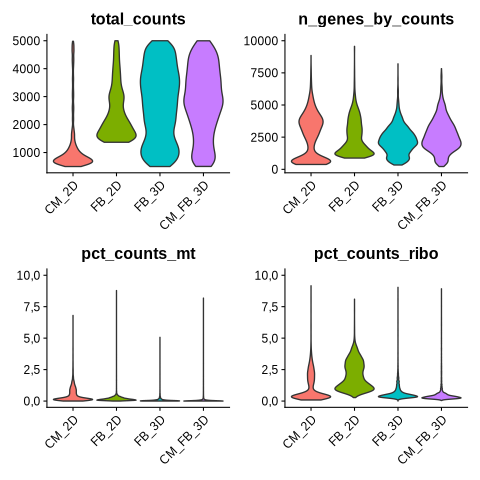

In [48]:
%%R

adata <- readH5AD("microtissue_before_quality_control.h5ad")

# 2. Konwertuj do SeuratObject
seurat_obj <- as.Seurat(adata, counts = "X", data=NULL)
#seurat_obj <- NormalizeData(seurat_obj) 

p1 <- VlnPlot(seurat_obj, features = "total_counts", group.by = "sample", pt.size = 0, y.max = 5000) +
      theme(axis.title.x = element_blank()) + NoLegend()

p2 <- VlnPlot(seurat_obj, features = "n_genes_by_counts", group.by = "sample", pt.size = 0, y.max = 10000) +
      theme(axis.title.x = element_blank()) + NoLegend()

p3 <- VlnPlot(seurat_obj, features = "pct_counts_mt", group.by = "sample", pt.size = 0, y.max = 10) +
      theme(axis.title.x = element_blank()) + NoLegend()

p4 <- VlnPlot(seurat_obj, features = "pct_counts_ribo", group.by = "sample", pt.size = 0, y.max = 10) +
      theme(axis.title.x = element_blank()) + NoLegend()

# 4. Połącz w layout 2x2
QC_pre_VlnPlots_zoom <- p1 + p2 + p3 + p4 + plot_layout(ncol = 2)

# 5. Wyświetl
QC_pre_VlnPlots_zoom

In [49]:
adata = adata[
    (adata.obs["total_counts"] > 500) &
    (adata.obs["n_genes_by_counts"] > 2000),
].copy()

###### mitochondrial outliers for sn nuclei - e.g. 3 MADs or >8%:

In [50]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    9039
True     1400
Name: count, dtype: int64

###### We now filter our AnnData object based on these two additional columns:

In [51]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 10439
Number of cells after filtering of low quality cells: 8819


In [52]:
adata.write("microtissue_quality_control_v2.h5ad")

<sys>:0: FutureWarning: Use varm (e.g. `k in adata.varm` or `adata.varm.keys() | {'u'}`) instead of AnnData.varm_keys, AnnData.varm_keys is deprecated and will be removed in the future.
<sys>:0: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
R callback write-console: Dodatkowo:   
R callback write-console: Komunikaty ostrzegawcze:
  
R callback write-console: 1: Removed 6857 rows containing non-finite outside the scale range
(`stat_ydensity()`). 
  
R callback write-console: 2: Removed 3 rows containing non-finite outside the scale range
(`stat_ydensity()`). 
  


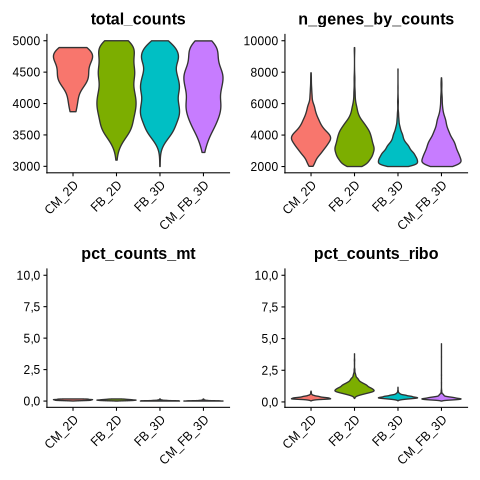

In [53]:
%%R

adata_v2 <- readH5AD("microtissue_quality_control_v2.h5ad")

# 2. Konwertuj do SeuratObject
seurat_obj_v2 <- as.Seurat(adata_v2, counts = "X", data=NULL)
#seurat_obj <- NormalizeData(seurat_obj) 

p1 <- VlnPlot(seurat_obj_v2, features = "total_counts", group.by = "sample", pt.size = 0, y.max = 5000) +
      theme(axis.title.x = element_blank()) + NoLegend()

p2 <- VlnPlot(seurat_obj_v2, features = "n_genes_by_counts", group.by = "sample", pt.size = 0, y.max = 10000) +
      theme(axis.title.x = element_blank()) + NoLegend()

p3 <- VlnPlot(seurat_obj_v2, features = "pct_counts_mt", group.by = "sample", pt.size = 0, y.max = 10) +
      theme(axis.title.x = element_blank()) + NoLegend()

p4 <- VlnPlot(seurat_obj_v2, features = "pct_counts_ribo", group.by = "sample", pt.size = 0, y.max = 10) +
      theme(axis.title.x = element_blank()) + NoLegend()

# 4. Połącz w layout 2x2
QC_pre_VlnPlots_zoom <- p1 + p2 + p3 + p4 + plot_layout(ncol = 2)

# 5. Wyświetl
QC_pre_VlnPlots_zoom

In [54]:
np.max(adata.X)

np.float32(15641.0)

In [55]:
adata.layers["counts"] = adata.X.copy()

###### Doublet detection

###### We first load some additional python and R packages:

In [56]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

Ładowanie wymaganego pakietu: scuttle


In [57]:
data_mat = adata.X.T

In [58]:
data_dense = data_mat.toarray()

###### We can now launch the doublet detection by using data_dense as input to scDblFinder:

In [59]:
%%R -i data_dense -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts = data_dense),
    )
)

doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~7056 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1082 cells excluded from training.
iter=1, 1082 cells excluded from training.
iter=2, 1082 cells excluded from training.
Threshold found:0,307
792 (9%) doublets called


In [60]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    8027
doublet     792
Name: count, dtype: int64

###### Normalization:

###### We can now inspect the distribution of the raw_counts which we already did during QC:

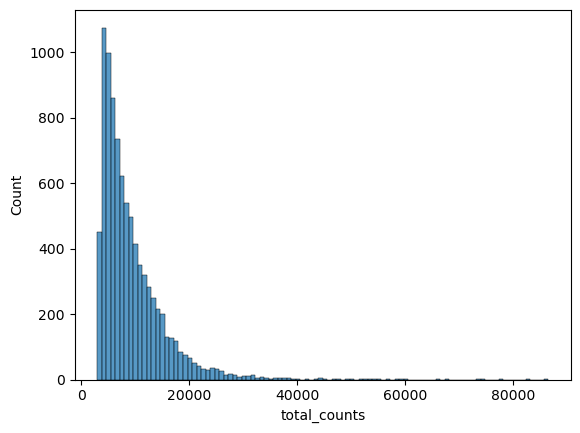

In [61]:
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

###### We will aply shifted logarithm as our normalization method of choice:

In [62]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

###### We can now inspect how the distribution of counts changed after we applied shifted logarithm

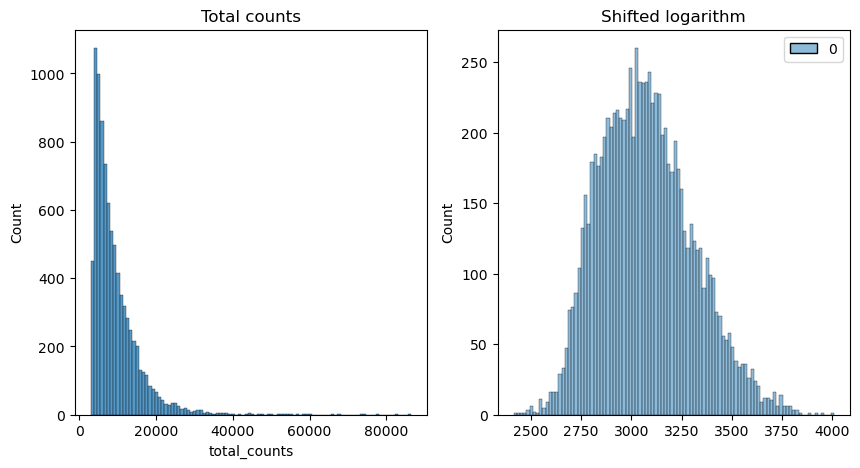

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

### Integration:

In [65]:
!pip install bbknn

/bin/bash: /home/maksn/anaconda3/envs/DCM_cardio/lib/libtinfo.so.6: no version information available (required by /bin/bash)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 6.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [bbknn]]


In [68]:
import scanpy as sc
import harmonypy as hm
import bbknn
import scanorama  # pip install scanorama

In [70]:
# Rozdzielamy dane na próbki
adatas_po_QC = {
    s: adata[adata.obs["sample"] == s].copy()
    for s in adata.obs["sample"].unique()
}

for key, ad in adatas_po_QC.items():
    # 1. Normalizacja
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)

    # 2. HVG dla tego sample (na razie lokalnie)
    sc.pp.highly_variable_genes(ad, flavor="seurat_v3", n_top_genes=3000)

    # 3. Regresja percent.mt
    sc.pp.regress_out(ad, ["pct_counts_mt"])

    # 4. Skalowanie
    sc.pp.scale(ad, max_value=10)

    # zapisanie z powrotem
    adatas_po_QC[key] = ad


/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


In [71]:
import anndata as ad

adata_merged = ad.concat(
    adatas_po_QC,        # słownik sample -> AnnData
    label="sample"       # dodaje kolumnę .obs["sample"]
)

In [72]:
sc.pp.highly_variable_genes(
    adata_merged,
    flavor="cell_ranger",  # inna metoda wyboru HVG, można też "seurat_v3"
    n_top_genes=3000,
    batch_key="sample"  # uwzględnia różne sample
)

In [73]:
adata_merged = adata_merged[:, adata_merged.var["highly_variable"]].copy()

In [74]:
sc.pp.scale(adata_merged, max_value=10)
sc.tl.pca(adata_merged, svd_solver="arpack")

### HARMONY:

In [ ]:
ho = hm.run_harmony(adata_merged.obsm['X_pca'], adata_merged.obs, 'sample')

# przypisanie do obsm bez transpozycji
adata_merged.obsm['X_pca_harmony'] = ho.Z_corr
#print(adata_merged.obsm['X_pca_harmony'].shape)

2026-02-16 15:32:33,154 - harmonypy - INFO - Running Harmony (PyTorch on cpu)
2026-02-16 15:32:33,154 - harmonypy - INFO -   Parameters:
2026-02-16 15:32:33,154 - harmonypy - INFO -     max_iter_harmony: 10
2026-02-16 15:32:33,155 - harmonypy - INFO -     max_iter_kmeans: 20
2026-02-16 15:32:33,155 - harmonypy - INFO -     epsilon_cluster: 1e-05
2026-02-16 15:32:33,155 - harmonypy - INFO -     epsilon_harmony: 0.0001
2026-02-16 15:32:33,156 - harmonypy - INFO -     nclust: 100
2026-02-16 15:32:33,156 - harmonypy - INFO -     block_size: 0.05
2026-02-16 15:32:33,156 - harmonypy - INFO -     lamb: [1. 1. 1. 1.]
2026-02-16 15:32:33,157 - harmonypy - INFO -     theta: [2. 2. 2. 2.]
2026-02-16 15:32:33,158 - harmonypy - INFO -     sigma: [0.1 0.1 0.1 0.1 0.1]...
2026-02-16 15:32:33,158 - harmonypy - INFO -     verbose: True
2026-02-16 15:32:33,158 - harmonypy - INFO -     random_state: 0
2026-02-16 15:32:33,160 - harmonypy - INFO -   Data: 50 PCs × 8819 cells
2026-02-16 15:32:33,160 - harmo

(8819, 50)


### BBKNN:

In [78]:
bbknn.bbknn(adata_merged, batch_key='sample', n_pcs=50)

### SCANORAMA:

In [87]:
adatas_list = [adata_merged[adata_merged.obs['sample']==b].copy()
               for b in adata_merged.obs['sample'].unique()]

# 1️⃣ Scanorama - poprawia embeddings i counts
# return_dimred=True -> zwraca X_scanorama w obsm
adatas_scanorama = scanorama.correct_scanpy(adatas_list, return_dimred=True)

# 2️⃣ Concatenate w jeden AnnData
# tutaj można użyć uns_merge="unique", żeby nie nadpisywać metadanych
adata_scanorama = sc.concat(
    adatas_scanorama,
    label="sample",
    uns_merge="unique",
    index_unique="-"
)

Found 3000 genes among all datasets
[[0.         0.86974444 0.61005771 0.29018961]
 [0.         0.         0.78504673 0.25921967]
 [0.         0.         0.         0.55478354]
 [0.         0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)
Processing datasets (2, 3)
Processing datasets (0, 3)
Processing datasets (1, 3)


### Leiden dla wielu rozdzielczości:

In [80]:
resolutions = [x/100 for x in range(5, 85, 5)]  # 0.05 -> 0.80 co 0.05

In [82]:
# --- Harmony
sc.pp.neighbors(adata_merged, use_rep='X_pca_harmony')
for r in resolutions:
    sc.tl.leiden(adata_merged, resolution=r, key_added=f'leiden_harmony_{r:.2f}')

In [83]:
# --- BBKNN (neighbors już ustawione przez bbknn)
for r in resolutions:
    sc.tl.leiden(adata_merged, resolution=r, key_added=f'leiden_bbknn_{r:.2f}')

In [88]:
# --- Scanorama
sc.pp.neighbors(adata_scanorama, use_rep='X_scanorama')
for r in resolutions:
    sc.tl.leiden(adata_scanorama, resolution=r, key_added=f'leiden_scanorama_{r:.2f}')

In [92]:
# --- UMAP
sc.tl.umap(adata_merged)
sc.tl.umap(adata_scanorama)

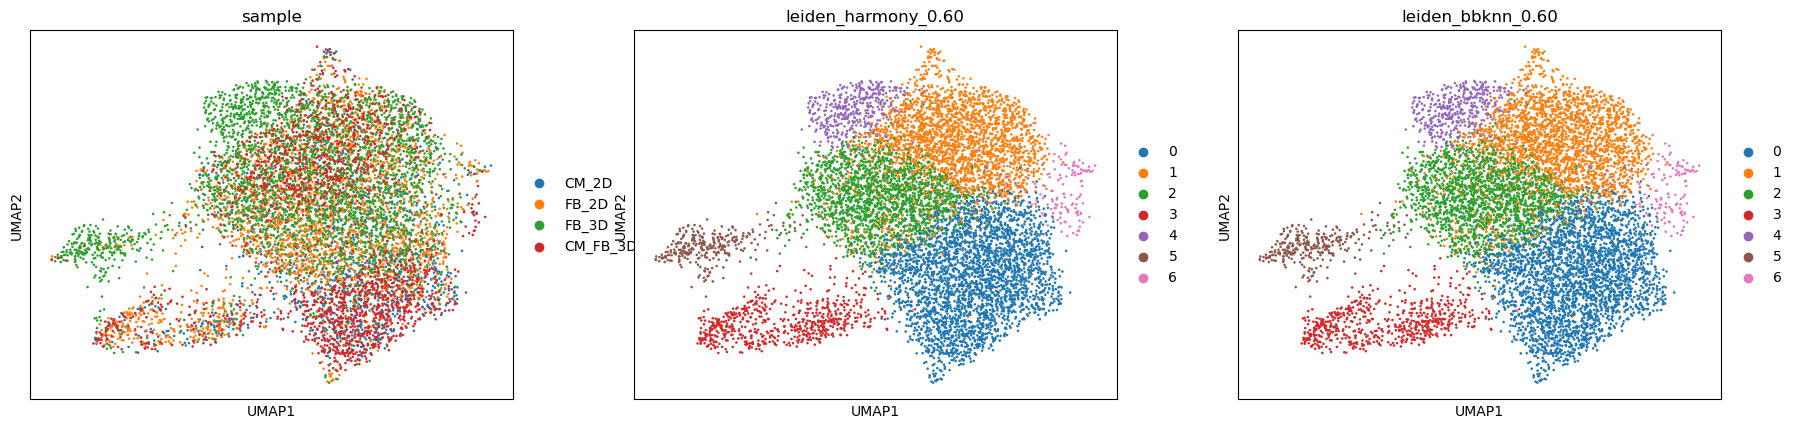

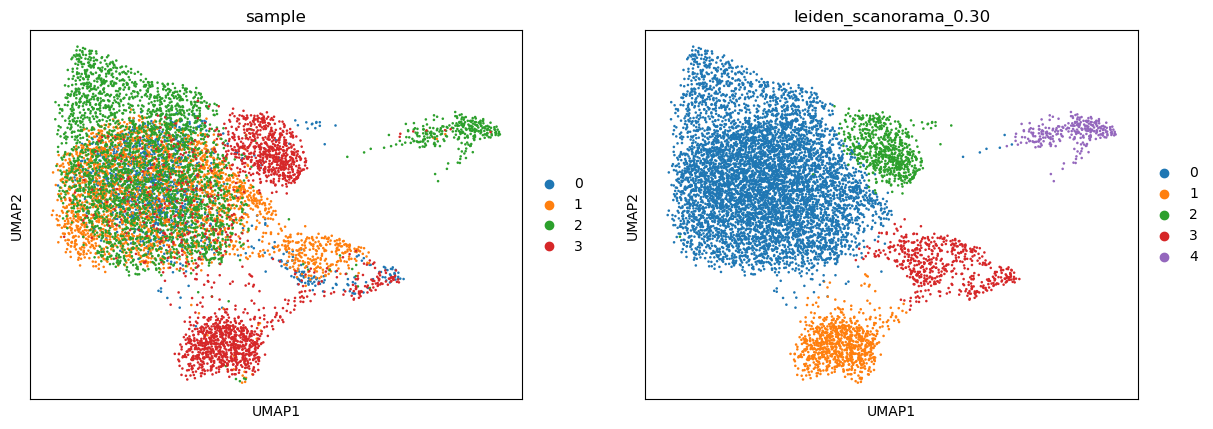

In [94]:
sc.pl.umap(adata_merged, color=['sample','leiden_harmony_0.60','leiden_bbknn_0.60'])
sc.pl.umap(adata_scanorama, color=['sample','leiden_scanorama_0.30'])

In [101]:
adata_scanorama

AnnData object with n_obs × n_vars = 8819 × 3000
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'leiden_harmony_0.05', 'leiden_harmony_0.10', 'leiden_harmony_0.15', 'leiden_harmony_0.20', 'leiden_harmony_0.25', 'leiden_harmony_0.30', 'leiden_harmony_0.35', 'leiden_harmony_0.40', 'leiden_harmony_0.45', 'leiden_harmony_0.50', 'leiden_harmony_0.55', 'leiden_harmony_0.60', 'leiden_harmony_0.65', 'leiden_harmony_0.70', 'leiden_harmony_0.75', 'leiden_harmony_0.80', 'leiden_bbknn_0.05', 'leiden_bbknn_0.10', 'leiden_bbknn_0.15', 'leiden_bbknn_0.20', 'leiden_bbknn_0.25', 'leiden_bbknn_0.30', 'leiden_bbknn_0.35', 'leiden_bbknn_0.40', 'leiden_bbknn_0.45', 'le

In [102]:
sc.tl.rank_genes_groups(adata_scanorama, groupby="leiden_scanorama_0.30", method="t-test")

# Pobranie wyników do DataFrame
markers = []
groups = adata_scanorama.obs['leiden_scanorama_0.30'].unique()
for g in groups:
    df = sc.get.rank_genes_groups_df(adata_scanorama, group=g)
    # tylko pozytywne, min.pct >0.5 i logfc>1
    df = df[(df['logfoldchanges'] > 1) & (df['pvals_adj'] > 0.5)]
    df['cluster'] = g
    markers.append(df)

markers_df = pd.concat(markers, ignore_index=True)

markers_unique = (
    markers_df
    .sort_values("logfoldchanges", ascending=False)
    .drop_duplicates(subset="names", keep="first")
)

markers_unique.to_csv('Microtissue_Markers_unique.csv', index=False)

# ---------------------------
# 5️⃣ Top 10 i top 3 genów wg logfc dla każdej grupy
# ---------------------------
markers_top10_unique = markers_unique.groupby('cluster').apply(lambda x: x.nlargest(10, 'logfoldchanges')).reset_index(drop=True)
markers_top10_unique.to_csv('microtissue_Markers_top10_unique.csv', index=False)

markers_top3_unique = markers_unique.groupby('cluster').apply(lambda x: x.nlargest(3, 'logfoldchanges')).reset_index(drop=True)
markers_top3_unique.to_csv('microtissue_Markers_top3_unique.csv', index=False)

/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2

In [103]:
# ---------------------------
# 6️⃣ Heatmap top 10 genów (losowe 20k komórek, jeśli masz więcej)
# ---------------------------
top_genes = markers_top10_unique['names'].unique()
if adata_scanorama.n_obs > 20000:
    idx = np.random.choice(adata_scanorama.n_obs, 20000, replace=False)
    adata_sub = adata_scanorama[idx, :].copy()
else:
    adata_sub = adata_scanorama

# Pobranie danych RNA dla genów top10
data = adata_sub[:, top_genes].X
if isinstance(data, np.ndarray):
    df_heat = pd.DataFrame(data, columns=top_genes)
else:
    # jeśli sparse matrix
    df_heat = pd.DataFrame(data.toarray(), columns=top_genes)

# Znormalizuj do 0-1 na gen
df_heat = (df_heat - df_heat.min()) / (df_heat.max() - df_heat.min())

# Tworzymy kolorową mapę jak w R
cmap = sns.color_palette("RdBu_r", 256)

/tmp/ipykernel_2110720/1105453933.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r', 256)  # 'RdBu_r' = reversed RdBu


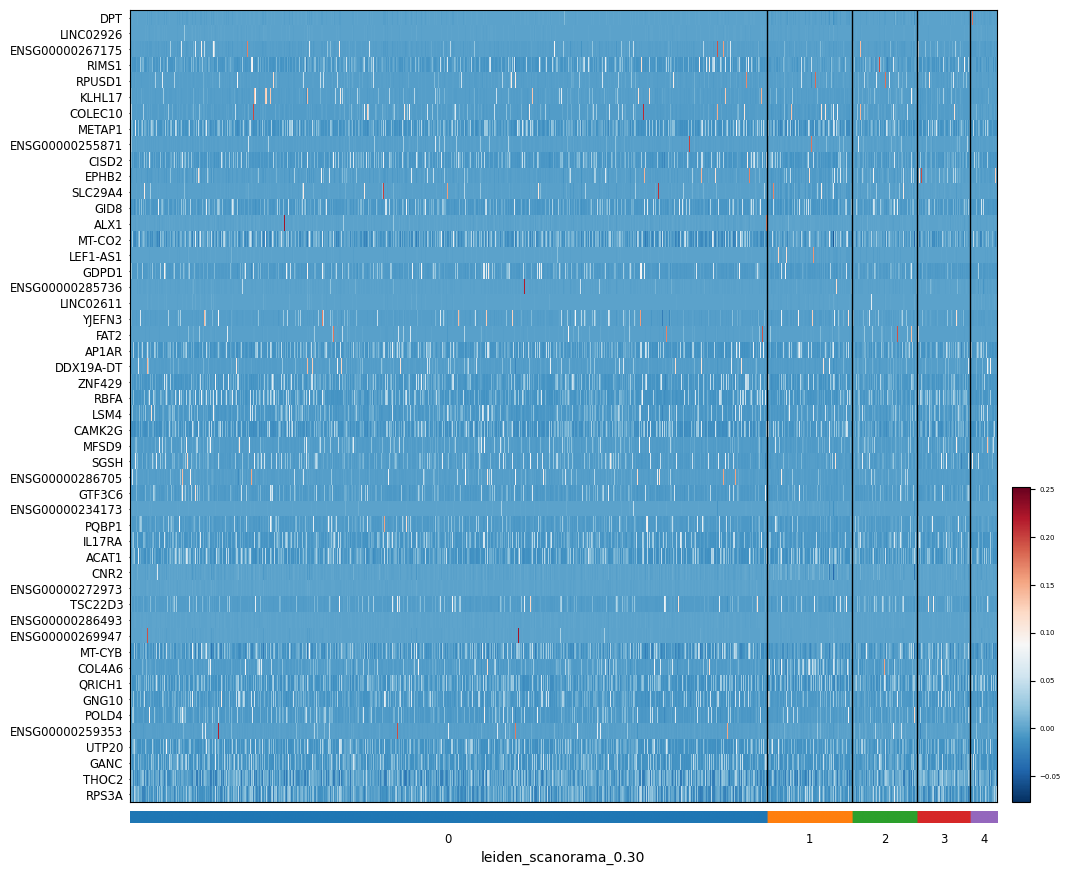

In [106]:
from matplotlib import cm
cmap = cm.get_cmap('RdBu_r', 256)  # 'RdBu_r' = reversed RdBu
# można też ręcznie odwrócić, ale RdBu_r jest już od czerwonego do niebieskiego

# -------------------------------
# 2️⃣ Losowe 20000 komórek (jeśli tyle masz)
# -------------------------------
if adata_scanorama.n_obs > 20000:
    sampled_cells = np.random.choice(adata_scanorama.obs_names, size=20000, replace=False)
else:
    sampled_cells = adata_scanorama.obs_names

adata_sampled = adata_scanorama[sampled_cells, :].copy()
# -------------------------------
# 3️⃣ Lista genów do heatmapy (top 10 markerów)
# -------------------------------
top_genes = markers_top10_unique['names'].unique().tolist()

sc.pl.heatmap(
    adata_sampled,
    var_names=top_genes,
    groupby='leiden_scanorama_0.30',            # lub inny klucz klastrów
    use_raw=False,                 # analog SCT assay
    swap_axes=True,               # żeby geny w osi y jak w Seurat
    cmap=cmap,
    show=False
)

# Dodatkowa stylizacja jak w R
plt.gca().tick_params(axis='y', labelsize=5)  # wielkość tekstu
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95)  # marginesy
plt.show()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

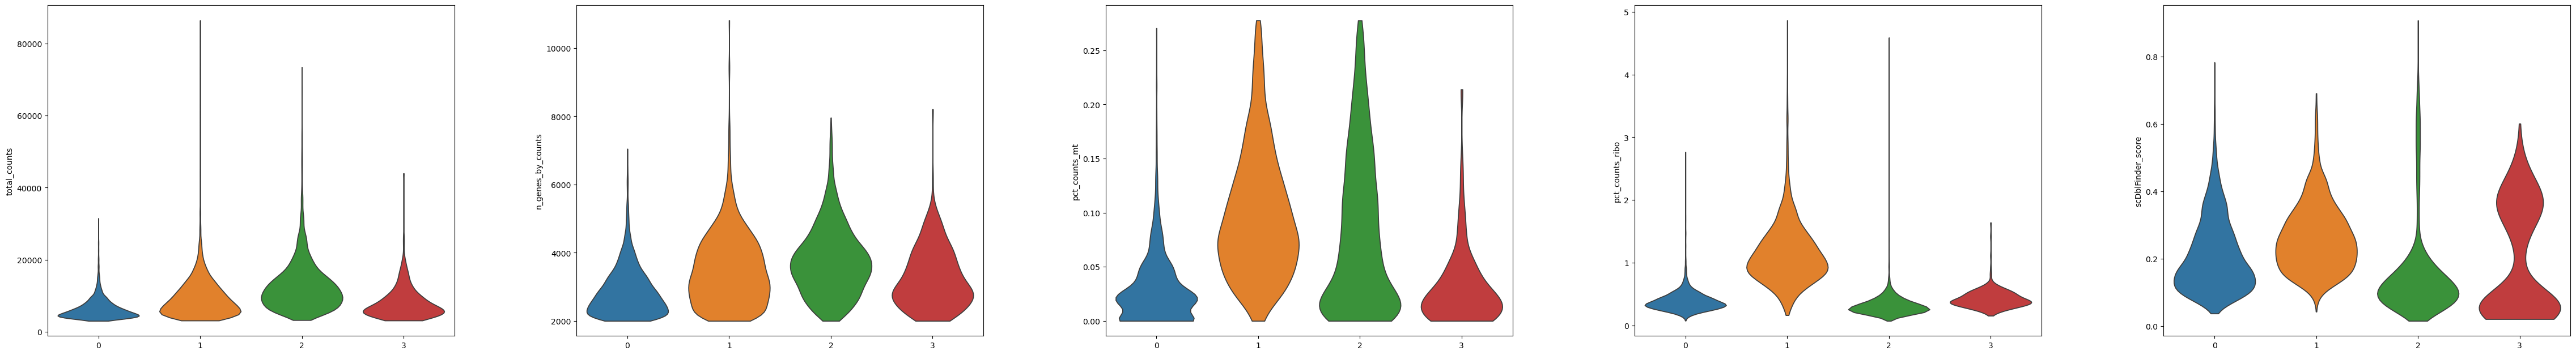

In [ ]:
features = ['total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'pct_counts_ribo', 'scDblFinder_score']

# Rysowanie violin plot
sc.pl.violin(
    adata_scanorama,           # analog DCM_RV
    keys=features,               # kolumny z adata.obs lub geny w adata.raw.var_names
    groupby='cluster',           # jeśli chcesz podzielić po klastrach
    multi_panel=True,            # osobne panele jak w ncol=3
    rotation=0,                  # obrót etykiet
    size=0,                      # pt.size=0 → nie rysuj punktów pojedynczych komórek
    show=False
)

# Usuń tytuł osi X, analog theme(axis.title.x = element_blank())
plt.xlabel('')
plt.show()

###### Automated Cell Annotation:

In [295]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

from numba.core.errors import NumbaDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

In [299]:
import urllib.request
from pathlib import Path

import celltypist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
#import scarches as sca
import seaborn as sns
from celltypist import models
from scipy.sparse import csr_matrix

In [300]:
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)